In [1]:
import numpy as np

import dolfinx
import ufl
from basix.ufl import blocked_element, element, enriched_element, mixed_element
from dolfinx.fem import Function, functionspace, dirichletbc, Expression, locate_dofs_topological
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary
from ufl import grad, inner, split
from dolfinx import plot
from dolfinx.nls.petsc import NewtonSolver

from tqdm import tqdm

from mpi4py import MPI
from petsc4py import PETSc

import pyvista

In [2]:
from pathlib import Path

results_folder = Path("results/nonlinear_Naghdi/pinched-cylinder")
results_folder.mkdir(exist_ok=True, parents=True)

pyvista.start_xvfb()

# Material and geometry parameters

In [3]:
r = 100.0
L = 200.0 / 2 
E, nu = 30.0E3, 0.3
mu = E/(2.0*(1.0 + nu)) 
lmbda = 2.0*mu*nu/(1.0 - 2.0*nu) 
t = 1.0 

# Parameter Space

In [4]:
cell_type = CellType.quadrilateral
mesh = create_rectangle(MPI.COMM_WORLD, np.array([[0.0, 0.0], [r * np.pi / 2, L]]), [200, 200], cell_type)

# topology dimension = 2
tdim = mesh.topology.dim
fdim = tdim - 1

## Plot

In [ ]:
topology, cell_types, geometry = plot.vtk_mesh(mesh, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter(off_screen = True)
plotter.add_mesh(grid, show_edges=True)
plotter.show_grid()
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot(results_folder/f"mesh_rank{mesh.comm.rank}.png")

plotter.close()

# Initial shape

In [5]:
x = ufl.SpatialCoordinate(mesh)
phi0_ufl = ufl.as_vector([r * ufl.sin(x[0] / r), x[1], r * ufl.cos(x[0] / r)])

def unit_normal(phi):
    n = ufl.cross(phi.dx(0), phi.dx(1))
    return n/ufl.sqrt(inner(n, n))

n0_ufl = unit_normal(phi0_ufl)

In [6]:
# for the 3 translation DOFs, we use the P2 + B3 enriched element
cell = mesh.basix_cell()
P1 = element("Lagrange", cell, degree=1)
P2 = element("Lagrange", cell, degree=2)
B3 = element("Bubble", cell, degree=3)

## Plot

In [8]:
# create a FEM interpolation of n0 and phi0
P1_d3_FS = functionspace(mesh, blocked_element(P1, shape = (3,)))

n0_P1_expr = Expression(n0_ufl, P1_d3_FS.element.interpolation_points())
n0_P1_func = Function(P1_d3_FS)
n0_P1_func.interpolate(n0_P1_expr)

phi0_P1_expr = Expression(phi0_ufl, P1_d3_FS.element.interpolation_points())
phi0_P1_func = Function(P1_d3_FS)
phi0_P1_func.interpolate(phi0_P1_expr)

topology, cell_types, geometry = plot.vtk_mesh(P1_d3_FS)

geometry_phi0_P1 = phi0_P1_func.x.array.reshape((geometry.shape[0], len(phi0_P1_func)))
geometry_n0_P1 = n0_P1_func.x.array.reshape((geometry.shape[0], len(n0_P1_func)))

grid_phi0_P1 = pyvista.UnstructuredGrid(topology, cell_types, geometry_phi0_P1)
grid_phi0_P1["n0"] = geometry_n0_P1
glyphs = grid_phi0_P1.glyph(orient="n0", factor=5)


plotter = pyvista.Plotter(off_screen = True)
plotter.add_mesh(grid_phi0_P1, style="wireframe", color="k")
plotter.add_mesh(glyphs,  show_scalar_bar=True, scalar_bar_args={"vertical": True})
plotter.show_grid()
plotter.enable_parallel_projection()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot(results_folder/f"initial_shape_rank{mesh.comm.rank}.png")
    
plotter.close()

Widget(value='<iframe src="http://localhost:37149/index.html?ui=P_0x7fba1c0807d0_0&reconnect=auto" class="pyvi…

# Director

In [7]:
def tangent_1(n):
    e2 = ufl.as_vector([0, 1, 0])
    t1 = ufl.cross(e2, n)
    t1 = t1/ufl.sqrt(inner(t1, t1))
    return t1

def tangent_2(n, t1):
    t2 = ufl.cross(n, t1)
    t2 = t2/ufl.sqrt(inner(t2, t2))
    return t2

# the analytical expression of t1 and t2
t1_ufl = tangent_1(n0_ufl)
t2_ufl = tangent_2(n0_ufl, t1_ufl)

# the analytical expression of R0
def rotation_matrix(t1, t2, n):
    R = ufl.as_matrix([[t1[0], t2[0], n[0]], 
                       [t1[1], t2[1], n[1]], 
                       [t1[2], t2[2], n[2]]])
    return R

R0_ufl = rotation_matrix(t1_ufl, t2_ufl, n0_ufl)

# Update the director with two successive elementary rotations
def director(R0, theta):
    Lm3 = ufl.as_vector([ufl.sin(theta[1])*ufl.cos(theta[0]), -ufl.sin(theta[0]), ufl.cos(theta[1])*ufl.cos(theta[0])])
    d = ufl.dot(R0, Lm3)
    return d

# Shell element

In [8]:
enriched = True
if cell_type == CellType.triangle:
    if enriched:
        P2B3 = enriched_element([P2, B3])
        naghdi_shell_element = mixed_element(
            [blocked_element(P2B3, shape=(3,)), blocked_element(P2, shape=(2,))]
        )
    else:
        naghdi_shell_element = mixed_element(
            [blocked_element(P2, shape=(3,)), blocked_element(P2, shape=(2,))]
        )
    
elif cell_type == CellType.quadrilateral:
    naghdi_shell_element = mixed_element(
        [blocked_element(P2, shape=(3,)), blocked_element(P2, shape=(2,))]
    )
    
naghdi_shell_FS = functionspace(mesh, naghdi_shell_element)

q_func = Function(naghdi_shell_FS) # current configuration
q_trial = ufl.TrialFunction(naghdi_shell_FS)
q_test = ufl.TestFunction(naghdi_shell_FS)

u_func, theta_func = split(q_func) # current displacement and rotation

# Shell model

In [9]:
# current deformation gradient 
F = grad(u_func) + grad(phi0_ufl) 

# current director
d = director(R0_ufl, theta_func)

# initial metric and curvature tensor a0 and b0
a0_ufl = grad(phi0_ufl).T * grad(phi0_ufl)
b0_ufl = -0.5*( grad(phi0_ufl).T * grad(n0_ufl) + grad(n0_ufl).T * grad(phi0_ufl))

def epsilon(F):
    """Membrane strain"""
    return 0.5 * (F.T * F - a0_ufl)


def kappa(F, d):
    """Bending strain"""
    return -0.5 * (F.T * grad(d) + grad(d).T * F) - b0_ufl


def gamma(F, d):
    """Transverse shear strain"""
    return F.T * d

a0_contra_ufl = ufl.inv(a0_ufl)
j0_ufl = ufl.det(a0_ufl)

i,j,l,m = ufl.indices(4)  # noqa: E741
A_contra_ufl = ufl.as_tensor( ( ((2.0*lmbda*mu) / (lmbda + 2.0*mu)) * a0_contra_ufl[i,j]*a0_contra_ufl[l,m]
                + 1.0*mu* (a0_contra_ufl[i,l]*a0_contra_ufl[j,m] + a0_contra_ufl[i,m]*a0_contra_ufl[j,l]) )
                ,[i,j,l,m])

N = ufl.as_tensor(t * A_contra_ufl[i,j,l,m] * epsilon(F)[l,m], [i,j])

M = ufl.as_tensor( (t**3 / 12.0) * A_contra_ufl[i,j,l,m]*kappa(F, d)[l,m], [i,j])

T = ufl.as_tensor( (t * mu *5.0 / 6.0) * a0_contra_ufl[i, j] * gamma(F, d)[j], [i])

psi_m = 0.5*inner(N, epsilon(F))

psi_b = 0.5*inner(M, kappa(F, d))

psi_s = 0.5*inner(T, gamma(F, d))

# Weak form Equation with PSRI

In [10]:
# Full integration of order 4
dx_f = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 4})

# Reduced integration of order 2
dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 2})

# Calculate the factor alpha as a function of the mesh size h
h = ufl.CellDiameter(mesh)
alpha_FS = functionspace(mesh, element("DG", cell, 0))
alpha_expr = Expression(t**2 / h**2, alpha_FS.element.interpolation_points())
alpha = Function(alpha_FS)
alpha.interpolate(alpha_expr)

# Full integration part of the total elastic energy
Pi_PSRI = psi_b * ufl.sqrt(j0_ufl) * dx_f 
Pi_PSRI += alpha * psi_m * ufl.sqrt(j0_ufl) * dx_f
Pi_PSRI += alpha * psi_s * ufl.sqrt(j0_ufl) * dx_f

# Reduced integration part of the total elastic energy
Pi_PSRI += (1.0 - alpha) * psi_m * ufl.sqrt(j0_ufl) * dx_r
Pi_PSRI += (1.0 - alpha) * psi_s * ufl.sqrt(j0_ufl) * dx_r

# external work part (zero in this case)
W_ext = 0.0
Pi_PSRI -= W_ext

Residual = ufl.derivative(Pi_PSRI, q_func, q_test)
Jacobian = ufl.derivative(Residual, q_func, q_trial)

# Symmetric Boundary Conditions

In [11]:
u_FS, _ = naghdi_shell_FS.sub(0).collapse()
theta_FS, _ = naghdi_shell_FS.sub(1).collapse()

Q0 = naghdi_shell_FS.sub(0)
Q1 = naghdi_shell_FS.sub(1)

u_clamped = Function(u_FS) # default value is 0
theta_clamped = Function(theta_FS) # default value is 0

Top: $u_2 = \theta_1 = 0$

In [12]:
def top_boundary(x):
    return np.isclose(x[1], L)

top_facets = locate_entities_boundary(mesh, fdim, top_boundary)

# u2 = 0 on the top boundary
u_id = int(1)
symm_dofs_u_top = locate_dofs_topological((Q0.sub(u_id), u_FS.sub(u_id)), fdim, top_facets)
bc_u_top = dirichletbc(u_clamped, symm_dofs_u_top, Q0.sub(u_id))

# theta1 = 0 on the top boundary
theta_id = int(0)
symm_dofs_theta_top = locate_dofs_topological((Q1.sub(theta_id), theta_FS.sub(theta_id)), fdim, top_facets)
bc_theta_top = dirichletbc(theta_clamped, symm_dofs_theta_top, Q1.sub(theta_id))

Left: $u_1 = \theta_2 = 0$

In [13]:
def left_boundary(x):
    return np.isclose(x[0], 0.0)

left_facets = locate_entities_boundary(mesh, fdim, left_boundary)

# u1 = 0 on the left boundary
u_id = int(0)
symm_dofs_u_left = locate_dofs_topological((Q0.sub(u_id), u_FS.sub(u_id)), fdim, left_facets)
bc_u_left = dirichletbc(u_clamped, symm_dofs_u_left, Q0.sub(u_id))

# theta2 = 0 on the left boundary
theta_id = int(1)
symm_dofs_theta_left = locate_dofs_topological((Q1.sub(theta_id), theta_FS.sub(theta_id)), fdim, left_facets)
bc_theta_left = dirichletbc(theta_clamped, symm_dofs_theta_left, Q1.sub(theta_id))

Right: $u_3 = \theta_2 = 0$

In [14]:
def right_boundary(x):
    return np.isclose(x[0], r*np.pi/2)

right_facets = locate_entities_boundary(mesh, fdim, right_boundary)

# u3 = 0 on the right boundary
u_id = int(2)
symm_dofs_u_right = locate_dofs_topological((Q0.sub(u_id), u_FS.sub(u_id)), fdim, right_facets)
bc_u_right = dirichletbc(u_clamped, symm_dofs_u_right, Q0.sub(u_id))

# theta2 = 0 on the right boundary
theta_id = int(1)
symm_dofs_theta_right = locate_dofs_topological((Q1.sub(theta_id), theta_FS.sub(theta_id)), fdim, right_facets)
bc_theta_right = dirichletbc(theta_clamped, symm_dofs_theta_right, Q1.sub(theta_id))

# Rigid end diaphragms boundary conditions

Bottom: $u_1 = u_3 = 0$

In [15]:
def bottom_boundary(x):
    return np.isclose(x[1], 0.0)

bottom_facets = locate_entities_boundary(mesh, fdim, bottom_boundary)

# u1 = 0 on the bottom boundary
u_id = int(0)
rigid_dofs_u1_bottom = locate_dofs_topological((Q0.sub(u_id), u_FS.sub(u_id)), fdim, bottom_facets)
bc_u1_bottom = dirichletbc(u_clamped, rigid_dofs_u1_bottom, Q0.sub(u_id))

# u3 = 0 on the bottom boundary
u_id = int(2)
rigid_dofs_u3_bottom = locate_dofs_topological((Q0.sub(u_id), u_FS.sub(u_id)), fdim, bottom_facets)
bc_u3_bottom = dirichletbc(u_clamped, rigid_dofs_u3_bottom, Q0.sub(u_id))

In [16]:
bcs = [bc_u_top, bc_theta_top, 
       bc_u_left, bc_theta_left,
       bc_u_right, bc_theta_right,
       bc_u1_bottom, bc_u3_bottom]

# Point Source

In [17]:
def compute_cell_contributions(V, points):
    # Determine what process owns a point and what cells it lies within
    mesh = V.mesh
    _, _, owning_points, cells = dolfinx.cpp.geometry.determine_point_ownership(
        mesh._cpp_object, points, 1e-6)
    owning_points = np.asarray(owning_points).reshape(-1, 3)

    # Pull owning points back to reference cell
    mesh_nodes = mesh.geometry.x
    cmap = mesh.geometry.cmaps[0]
    ref_x = np.zeros((len(cells), mesh.geometry.dim),
                     dtype=mesh.geometry.x.dtype)
    for i, (point, cell) in enumerate(zip(owning_points, cells)):
        geom_dofs = mesh.geometry.dofmap[cell]
        ref_x[i] = cmap.pull_back(point.reshape(-1, 3), mesh_nodes[geom_dofs])

    # Create expression evaluating a trial function (i.e. just the basis function)
    u = ufl.TrialFunction(V.sub(0).sub(2))
    num_dofs = V.sub(0).sub(2).dofmap.dof_layout.num_dofs * V.sub(0).sub(2).dofmap.bs
    if len(cells) > 0:
        # NOTE: Expression lives on only this communicator rank
        expr = dolfinx.fem.Expression(u, ref_x, comm=MPI.COMM_SELF)
        values = expr.eval(mesh, np.asarray(cells, dtype=np.int32))
        # Strip out basis function values per cell
        basis_values = values[:num_dofs:num_dofs*len(cells)]
    else:
        basis_values = np.zeros(
            (0, num_dofs), dtype=dolfinx.default_scalar_type)
    return cells, basis_values

In [18]:
if mesh.comm.rank == 0:
    points = np.array([[0.0, L, 0.0]], dtype=mesh.geometry.x.dtype)
else:
    points = np.zeros((0, 3), dtype=mesh.geometry.x.dtype)

ps_cells, basis_values = compute_cell_contributions(naghdi_shell_FS, points)

# BB tree

In [19]:
bb_tree = dolfinx.geometry.bb_tree(mesh, 2)

bb_point_A = np.array([[0.0, L, 0.0]], dtype=np.float64)
bb_point_B = np.array([[r*np.pi/2, L, 0.0]], dtype=np.float64)

# Find the leaf that the target point is in
bb_cell_candidates_B = dolfinx.geometry.compute_collisions_points(bb_tree, bb_point_B)


# Find the cell from the leaf that contains the target point
bb_cells_B = dolfinx.geometry.compute_colliding_cells(
    mesh, bb_cell_candidates_B, bb_point_B)

# Solver

In [20]:
import typing
from dolfinx.fem.bcs import DirichletBC
from dolfinx.fem.function import Function as _Function
from dolfinx.fem.petsc import assemble_vector, apply_lifting, set_bc

class NonlinearProblemPointSource(NonlinearProblem):
    def __init__(self, F: ufl.form.Form, u: _Function, bcs: typing.List[DirichletBC] = [],
                 J: ufl.form.Form = None, cells = [], basis_values = [], PS: float = 0.0):
        
        super().__init__(F, u, bcs, J)
        
        self.PS = PS
        self.cells = cells
        self.basis_values = basis_values
        self.function_space = u.function_space
        
    def F(self, x: PETSc.Vec, b: PETSc.Vec) -> None:
        # Reset the residual vector
        with b.localForm() as b_local:
            b_local.set(0.0)
        assemble_vector(b, self._L)

        # Add point source
        if len(self.cells) > 0:
            for cell, basis_value in zip(self.cells, self.basis_values):
                dofs = self.function_space.sub(0).sub(2).dofmap.cell_dofs(cell)
                with b.localForm() as b_local:
                    b_local.setValuesLocal(dofs, basis_value * -self.PS, addv=PETSc.InsertMode.ADD_VALUES)
        
        # Apply boundary condition
        apply_lifting(b, [self._a], bcs=[self.bcs], x0=[x], scale=-1.0)
        b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b, self.bcs, x, -1.0)

In [25]:
problem = NonlinearProblemPointSource(Residual, q_func, bcs, Jacobian, ps_cells, basis_values)

solver = NewtonSolver(mesh.comm, problem)

# Set Newton solver options
solver.rtol = 1e-6
solver.atol = 1e-6
solver.max_it = 100
solver.convergence_criterion = "incremental"
solver.report = True

# Modify the linear solver in each Newton iteration
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "cg"
#opts[f"{option_prefix}pc_type"] = "lu"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

In [22]:
file_u = dolfinx.io.VTKFile(mesh.comm, results_folder/"u_naghdi.pvd", "w")
file_theta = dolfinx.io.VTKFile(mesh.comm, results_folder/"theta_naghdi.pvd", "w")
file_phi = dolfinx.io.VTKFile(mesh.comm, results_folder/"phi_naghdi.pvd", "w")

def write_files():
    u_P2B3 = q_func.sub(0).collapse()
    theta_P2 = q_func.sub(1).collapse()

    phi_FS = functionspace(mesh, blocked_element(P2, shape=(3,)))
    phi_expr = Expression(phi0_ufl + u_P2B3, phi_FS.element.interpolation_points())
    phi_func = Function(phi_FS)
    phi_func.interpolate(phi_expr)

    u_P2 = Function(phi_FS)
    u_P2.interpolate(u_P2B3)

    file_u.write_function(u_P2, i)
    file_theta.write_function(theta_P2, i)
    file_phi.write_function(phi_func, i)

def point_values():
    WA_bb = None
    UB_bb = None
    
    u1_func = q_func.sub(0).sub(0).collapse()
    u3_func = q_func.sub(0).sub(2).collapse()
    
    if len(ps_cells) > 0:
        WA_bb = u3_func.eval(bb_point_A, ps_cells[0])[0]
    WA_bb = mesh.comm.gather(WA_bb, root=0)
    
    if len(bb_cells_B.array) > 0:
        UB_bb = u1_func.eval(bb_point_B, bb_cells_B.array[0])[0]
    UB_bb = mesh.comm.gather(UB_bb, root=0)
    
    
    return WA_bb, UB_bb

In [23]:
PS_list1 = np.arange(0, -400, -40)
PS_list2 = np.arange(-400, -500, -5)
PS_list3 = np.linspace(-500, -3000, 51)
PS_list = np.hstack([PS_list1, PS_list2, PS_list3])
PS_max = PS_list[-1]
if mesh.comm.rank == 0:
    WA_list = np.zeros_like(PS_list)
    UB_list = np.zeros_like(PS_list)


q_func.x.array[:] = 0.0


#dolfinx.log.set_log_level(dolfinx.log.LogLevel.INFO)
#dolfinx.log.set_log_level(dolfinx.log.LogLevel.OFF)

for i, PS_curr in enumerate(tqdm(PS_list)):
    problem.PS = PS_curr
    n, converged = solver.solve(q_func)
    assert (converged)
    q_func.x.scatter_forward()
    if mesh.comm.rank == 0:
        print(f"Load step {i:d}, Number of iterations: {n:d}, Load: {problem.PS :.2f} ({PS_max})", flush=True)
    
    write_files()
    # calculate u3 at the point load
    WA_bb, UB_bb = point_values()
    if mesh.comm.rank == 0:
        for WA in WA_bb:
            if WA is not None:
                WA_list[i] = WA
                break
        
        for UB in UB_bb:
            if UB is not None:
                UB_list[i] = UB
                break
        


  0%|          | 0/81 [00:00<?, ?it/s]

Load step 0, Number of iterations: 2, Load: 0.00 (-3000.0)


  1%|          | 1/81 [00:23<31:23, 23.55s/it]

Load step 1, Number of iterations: 6, Load: -40.00 (-3000.0)


  2%|▏         | 2/81 [01:12<50:50, 38.61s/it]

Load step 2, Number of iterations: 8, Load: -80.00 (-3000.0)


  4%|▎         | 3/81 [02:15<1:04:31, 49.63s/it]

Load step 3, Number of iterations: 7, Load: -120.00 (-3000.0)


  5%|▍         | 4/81 [03:10<1:06:36, 51.91s/it]

Load step 4, Number of iterations: 7, Load: -160.00 (-3000.0)


  6%|▌         | 5/81 [04:06<1:07:15, 53.10s/it]

Load step 5, Number of iterations: 9, Load: -200.00 (-3000.0)


  7%|▋         | 6/81 [05:14<1:13:02, 58.43s/it]

Load step 6, Number of iterations: 11, Load: -240.00 (-3000.0)


  9%|▊         | 7/81 [06:37<1:21:53, 66.40s/it]

Load step 7, Number of iterations: 11, Load: -280.00 (-3000.0)


 10%|▉         | 8/81 [08:00<1:27:03, 71.55s/it]

Load step 8, Number of iterations: 9, Load: -320.00 (-3000.0)


 11%|█         | 9/81 [09:08<1:24:46, 70.65s/it]

Load step 9, Number of iterations: 8, Load: -360.00 (-3000.0)


 12%|█▏        | 10/81 [10:10<1:20:24, 67.95s/it]

Load step 10, Number of iterations: 10, Load: -400.00 (-3000.0)


 14%|█▎        | 11/81 [11:29<1:23:07, 71.25s/it]

Load step 11, Number of iterations: 6, Load: -405.00 (-3000.0)


 15%|█▍        | 12/81 [12:18<1:14:11, 64.51s/it]

Load step 12, Number of iterations: 6, Load: -410.00 (-3000.0)


 16%|█▌        | 13/81 [13:07<1:07:36, 59.65s/it]

Load step 13, Number of iterations: 6, Load: -415.00 (-3000.0)


 17%|█▋        | 14/81 [13:55<1:02:49, 56.27s/it]

Load step 14, Number of iterations: 7, Load: -420.00 (-3000.0)


 19%|█▊        | 15/81 [14:50<1:01:35, 55.99s/it]

Load step 15, Number of iterations: 7, Load: -425.00 (-3000.0)


 20%|█▉        | 16/81 [15:45<1:00:21, 55.72s/it]

Load step 16, Number of iterations: 8, Load: -430.00 (-3000.0)


 21%|██        | 17/81 [16:48<1:01:28, 57.63s/it]

Load step 17, Number of iterations: 9, Load: -435.00 (-3000.0)


 22%|██▏       | 18/81 [17:56<1:04:04, 61.02s/it]

Load step 18, Number of iterations: 10, Load: -440.00 (-3000.0)


 23%|██▎       | 19/81 [19:12<1:07:36, 65.43s/it]

Load step 19, Number of iterations: 13, Load: -445.00 (-3000.0)


 25%|██▍       | 20/81 [20:49<1:15:57, 74.72s/it]

Load step 20, Number of iterations: 10, Load: -450.00 (-3000.0)


 26%|██▌       | 21/81 [22:04<1:15:01, 75.02s/it]

Load step 21, Number of iterations: 10, Load: -455.00 (-3000.0)


 27%|██▋       | 22/81 [23:20<1:13:59, 75.25s/it]

Load step 22, Number of iterations: 10, Load: -460.00 (-3000.0)


 28%|██▊       | 23/81 [24:36<1:12:51, 75.38s/it]

Load step 23, Number of iterations: 8, Load: -465.00 (-3000.0)


 30%|██▉       | 24/81 [25:38<1:07:49, 71.40s/it]

Load step 24, Number of iterations: 7, Load: -470.00 (-3000.0)


 31%|███       | 25/81 [26:33<1:02:07, 66.57s/it]

Load step 25, Number of iterations: 7, Load: -475.00 (-3000.0)


 32%|███▏      | 26/81 [27:29<57:57, 63.22s/it]  

Load step 26, Number of iterations: 7, Load: -480.00 (-3000.0)


 33%|███▎      | 27/81 [28:24<54:47, 60.88s/it]

Load step 27, Number of iterations: 7, Load: -485.00 (-3000.0)


 35%|███▍      | 28/81 [29:19<52:20, 59.25s/it]

Load step 28, Number of iterations: 6, Load: -490.00 (-3000.0)


 36%|███▌      | 29/81 [30:08<48:36, 56.08s/it]

Load step 29, Number of iterations: 6, Load: -495.00 (-3000.0)


 37%|███▋      | 30/81 [30:57<45:43, 53.80s/it]

Load step 30, Number of iterations: 6, Load: -500.00 (-3000.0)


 38%|███▊      | 31/81 [31:45<43:36, 52.33s/it]

Load step 31, Number of iterations: 12, Load: -550.00 (-3000.0)


 40%|███▉      | 32/81 [33:15<51:49, 63.47s/it]

Load step 32, Number of iterations: 10, Load: -600.00 (-3000.0)


 41%|████      | 33/81 [34:31<53:43, 67.15s/it]

Load step 33, Number of iterations: 9, Load: -650.00 (-3000.0)


 42%|████▏     | 34/81 [35:40<53:02, 67.72s/it]

Load step 34, Number of iterations: 8, Load: -700.00 (-3000.0)


 43%|████▎     | 35/81 [36:42<50:41, 66.13s/it]

Load step 35, Number of iterations: 8, Load: -750.00 (-3000.0)


 44%|████▍     | 36/81 [37:45<48:47, 65.06s/it]

Load step 36, Number of iterations: 7, Load: -800.00 (-3000.0)


 46%|████▌     | 37/81 [38:40<45:32, 62.11s/it]

Load step 37, Number of iterations: 7, Load: -850.00 (-3000.0)


 47%|████▋     | 38/81 [39:35<43:04, 60.11s/it]

Load step 38, Number of iterations: 7, Load: -900.00 (-3000.0)


 48%|████▊     | 39/81 [40:31<41:07, 58.74s/it]

Load step 39, Number of iterations: 7, Load: -950.00 (-3000.0)


 49%|████▉     | 40/81 [41:26<39:25, 57.71s/it]

Load step 40, Number of iterations: 7, Load: -1000.00 (-3000.0)


 51%|█████     | 41/81 [42:22<38:07, 57.19s/it]

Load step 41, Number of iterations: 6, Load: -1050.00 (-3000.0)


 52%|█████▏    | 42/81 [43:11<35:30, 54.64s/it]

Load step 42, Number of iterations: 6, Load: -1100.00 (-3000.0)


 53%|█████▎    | 43/81 [43:59<33:25, 52.78s/it]

Load step 43, Number of iterations: 6, Load: -1150.00 (-3000.0)


 54%|█████▍    | 44/81 [44:48<31:48, 51.59s/it]

Load step 44, Number of iterations: 6, Load: -1200.00 (-3000.0)


 56%|█████▌    | 45/81 [45:37<30:25, 50.71s/it]

Load step 45, Number of iterations: 6, Load: -1250.00 (-3000.0)


 57%|█████▋    | 46/81 [46:25<29:09, 49.99s/it]

Load step 46, Number of iterations: 6, Load: -1300.00 (-3000.0)


 58%|█████▊    | 47/81 [47:14<28:06, 49.60s/it]

Load step 47, Number of iterations: 6, Load: -1350.00 (-3000.0)


 59%|█████▉    | 48/81 [48:02<27:06, 49.29s/it]

Load step 48, Number of iterations: 6, Load: -1400.00 (-3000.0)


 60%|██████    | 49/81 [48:51<26:10, 49.08s/it]

Load step 49, Number of iterations: 6, Load: -1450.00 (-3000.0)


 62%|██████▏   | 50/81 [49:40<25:16, 48.93s/it]

Load step 50, Number of iterations: 6, Load: -1500.00 (-3000.0)


 63%|██████▎   | 51/81 [50:28<24:24, 48.83s/it]

Load step 51, Number of iterations: 6, Load: -1550.00 (-3000.0)


 64%|██████▍   | 52/81 [51:17<23:35, 48.82s/it]

Load step 52, Number of iterations: 5, Load: -1600.00 (-3000.0)


 65%|██████▌   | 53/81 [51:59<21:49, 46.76s/it]

Load step 53, Number of iterations: 5, Load: -1650.00 (-3000.0)


 67%|██████▋   | 54/81 [52:41<20:23, 45.31s/it]

Load step 54, Number of iterations: 5, Load: -1700.00 (-3000.0)


 68%|██████▊   | 55/81 [53:22<19:09, 44.21s/it]

Load step 55, Number of iterations: 5, Load: -1750.00 (-3000.0)


 69%|██████▉   | 56/81 [54:04<18:06, 43.46s/it]

Load step 56, Number of iterations: 5, Load: -1800.00 (-3000.0)


 70%|███████   | 57/81 [54:46<17:12, 43.01s/it]

Load step 57, Number of iterations: 5, Load: -1850.00 (-3000.0)


 72%|███████▏  | 58/81 [55:28<16:19, 42.61s/it]

Load step 58, Number of iterations: 5, Load: -1900.00 (-3000.0)


 73%|███████▎  | 59/81 [56:10<15:33, 42.41s/it]

Load step 59, Number of iterations: 5, Load: -1950.00 (-3000.0)


 74%|███████▍  | 60/81 [56:52<14:47, 42.28s/it]

Load step 60, Number of iterations: 5, Load: -2000.00 (-3000.0)


 75%|███████▌  | 61/81 [57:34<14:02, 42.13s/it]

Load step 61, Number of iterations: 5, Load: -2050.00 (-3000.0)


 77%|███████▋  | 62/81 [58:15<13:19, 42.08s/it]

Load step 62, Number of iterations: 5, Load: -2100.00 (-3000.0)


 78%|███████▊  | 63/81 [58:57<12:36, 42.04s/it]

Load step 63, Number of iterations: 5, Load: -2150.00 (-3000.0)


 79%|███████▉  | 64/81 [59:39<11:53, 41.97s/it]

Load step 64, Number of iterations: 5, Load: -2200.00 (-3000.0)


 80%|████████  | 65/81 [1:00:21<11:11, 41.94s/it]

Load step 65, Number of iterations: 5, Load: -2250.00 (-3000.0)


 81%|████████▏ | 66/81 [1:01:03<10:28, 41.92s/it]

Load step 66, Number of iterations: 5, Load: -2300.00 (-3000.0)


 83%|████████▎ | 67/81 [1:01:45<09:45, 41.85s/it]

Load step 67, Number of iterations: 5, Load: -2350.00 (-3000.0)


 84%|████████▍ | 68/81 [1:02:27<09:04, 41.86s/it]

Load step 68, Number of iterations: 5, Load: -2400.00 (-3000.0)


 85%|████████▌ | 69/81 [1:03:08<08:21, 41.83s/it]

Load step 69, Number of iterations: 5, Load: -2450.00 (-3000.0)


 86%|████████▋ | 70/81 [1:03:50<07:39, 41.79s/it]

Load step 70, Number of iterations: 5, Load: -2500.00 (-3000.0)


 88%|████████▊ | 71/81 [1:04:32<06:57, 41.78s/it]

Load step 71, Number of iterations: 5, Load: -2550.00 (-3000.0)


 89%|████████▉ | 72/81 [1:05:13<06:15, 41.72s/it]

Load step 72, Number of iterations: 5, Load: -2600.00 (-3000.0)


 90%|█████████ | 73/81 [1:05:55<05:34, 41.81s/it]

Load step 73, Number of iterations: 5, Load: -2650.00 (-3000.0)


 91%|█████████▏| 74/81 [1:06:37<04:53, 41.87s/it]

Load step 74, Number of iterations: 5, Load: -2700.00 (-3000.0)


 93%|█████████▎| 75/81 [1:07:19<04:11, 41.87s/it]

Load step 75, Number of iterations: 5, Load: -2750.00 (-3000.0)


 94%|█████████▍| 76/81 [1:08:01<03:29, 41.82s/it]

Load step 76, Number of iterations: 5, Load: -2800.00 (-3000.0)


 95%|█████████▌| 77/81 [1:08:43<02:47, 41.90s/it]

Load step 77, Number of iterations: 5, Load: -2850.00 (-3000.0)


 96%|█████████▋| 78/81 [1:09:25<02:05, 41.90s/it]

Load step 78, Number of iterations: 5, Load: -2900.00 (-3000.0)


 98%|█████████▊| 79/81 [1:10:07<01:23, 41.85s/it]

Load step 79, Number of iterations: 5, Load: -2950.00 (-3000.0)


 99%|█████████▉| 80/81 [1:10:49<00:42, 42.14s/it]

Load step 80, Number of iterations: 5, Load: -3000.00 (-3000.0)


100%|██████████| 81/81 [1:11:31<00:00, 52.98s/it]


# Post-processing

In [36]:
u_P2B3 = q_func.sub(0).collapse()
theta_P2 = q_func.sub(1).collapse()

# Interpolate phi in the [P2]³ Space
phi_FS = functionspace(mesh, blocked_element(P2, shape=(3,)))
phi_expr = Expression(phi0_ufl + u_P2B3, phi_FS.element.interpolation_points())
phi_func = Function(phi_FS)
phi_func.interpolate(phi_expr)
topology, cell_types, geometry = plot.vtk_mesh(phi_FS)

geometry_phi = phi_func.x.array.reshape((geometry.shape[0], len(phi_func)))

grid_phi = pyvista.UnstructuredGrid(topology, cell_types, geometry_phi)

plotter = pyvista.Plotter()
plotter.add_mesh(grid_phi, show_edges=True)
plotter.show_grid()
plotter.enable_parallel_projection()
plotter.show_axes_all()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot(results_folder/"phi.png")
plotter.close()

Widget(value='<iframe src="http://localhost:41531/index.html?ui=P_0x7fdb4f5190d0_0&reconnect=auto" class="pyvi…

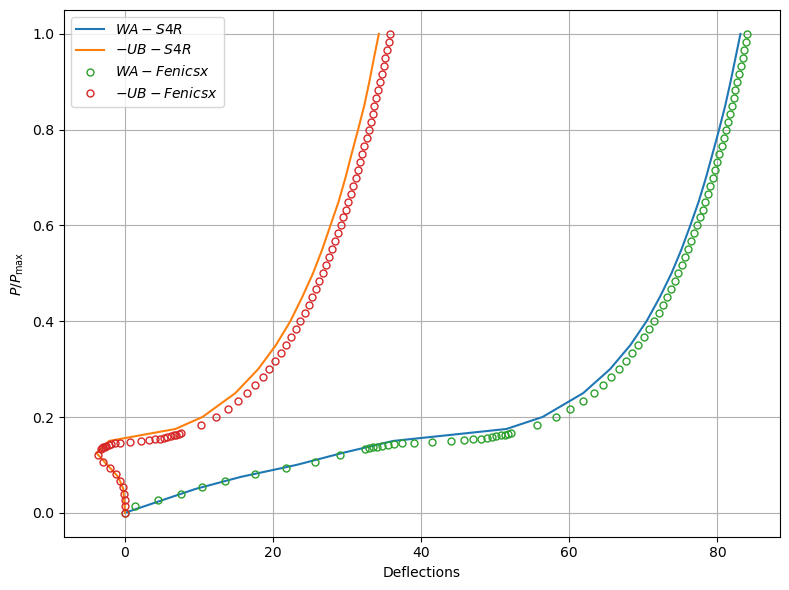

In [24]:
import matplotlib.pyplot as plt

if mesh.comm.rank == 0:
    np.savetxt(results_folder/"WA_list.txt", WA_list)
    np.savetxt(results_folder/"UB_list.txt", UB_list)
    np.savetxt(results_folder/"PS_list.txt", PS_list)
    P_S4R = np.array([0.00, 0.05, 0.075, 0.100, 0.125, 0.15, 0.175,
                      0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50,
                      0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85,
                      0.90, 0.95, 1.00])
    
    WA_S4R = np.array([0.00, 9.561, 15.648, 23.164, 29.375, 36.208, 51.499, 56.373,
                       61.877, 65.498, 68.229, 70.424, 72.204, 73.790, 75.139, 76.331,
                       77.472, 78.451, 79.339, 80.218, 81.045, 81.766, 82.435, 83.102])
    UB_S4R = np.array([0.00, -0.233, -0.922, -2.391, -3.872, -2.154, 6.792, 10.448,
                       14.905, 17.979, 20.365, 22.321, 23.916, 25.381, 26.631, 27.735,
                       28.843, 29.772, 30.604, 31.471, 32.299, 32.989, 33.619, 34.272])
    
    plt.figure(figsize=(8.0, 6.0))
    plt.plot(WA_S4R, P_S4R, "-", label="$WA-S4R$")
    plt.plot(UB_S4R, P_S4R, "-", label="$-UB-S4R$")
    plt.plot(-WA_list, PS_list / PS_max, "o", markersize=5, markerfacecolor='none', markevery = 1, label="$WA-Fenicsx$")
    plt.plot(UB_list, PS_list / PS_max, "o", markersize=5, markerfacecolor='none', markevery = 1, label="$-UB-Fenicsx$")
    plt.xlabel("Deflections")
    plt.ylabel(r"$P/P_{\mathrm{max}}$")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig(results_folder/"comparisons.png")